# **Step 1: Environment Setup**

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk tensorflow wordcloud
!pip install kaggle

# **Step 2: Load the Drive and Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data_path = '/content/drive/My Drive/file.csv'
df = pd.read_csv(data_path, encoding='latin-1')
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df = df[['target', 'date', 'user','text']]

# **Step 3: Data Preprocessing**

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(clean_text)
df = df[df['text'].str.strip() != '']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
 df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)


<Axes: xlabel='target'>

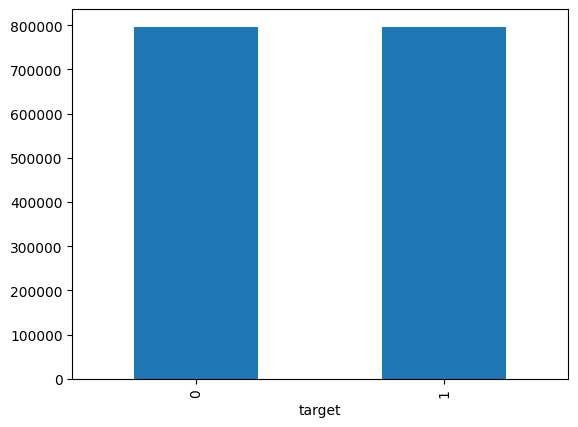

In [ ]:
df['target'].value_counts().plot(kind='bar')


# **Step 4: Exploratory Data Analysis (EDA)**

4.1 Basic Statistics and Word Clouds

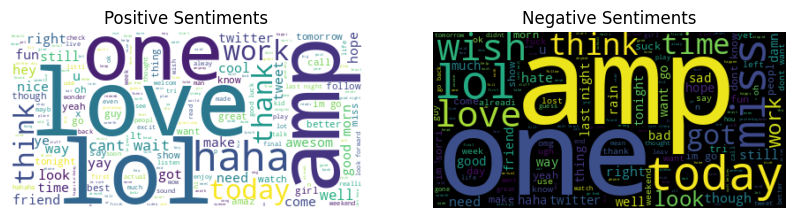

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_texts = ' '.join(df[df['target'] == 1]['text'])
negative_texts = ' '.join(df[df['target'] == 0]['text'])

wordcloud_positive = WordCloud(max_words=1000, background_color='white').generate(positive_texts)
wordcloud_negative = WordCloud(max_words=1000, background_color='black').generate(negative_texts)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiments')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiments')

plt.show()


4.2 Sentiment Distribution Over Time

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


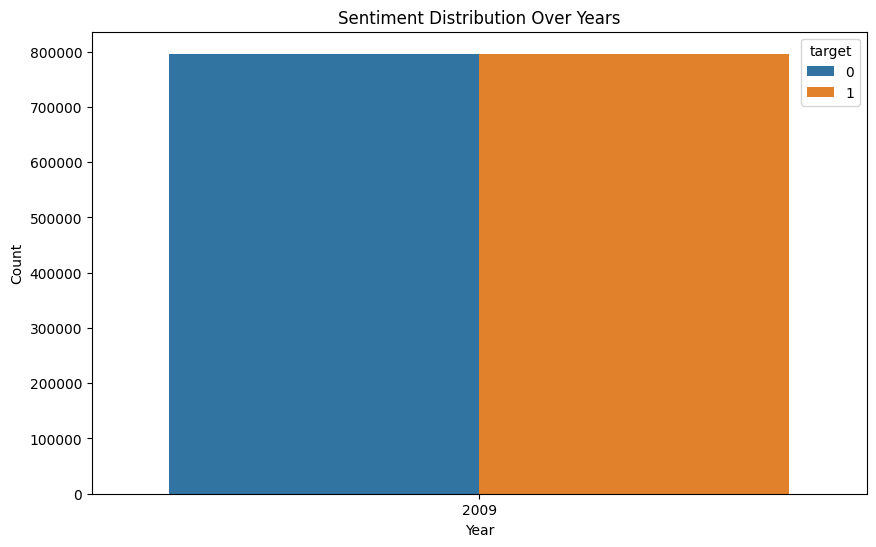

In [ ]:
# Extract year from the date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

# Plot sentiment distribution over years
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='year', hue='target')
plt.title('Sentiment Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


4.3 Sentiment Distribution by User

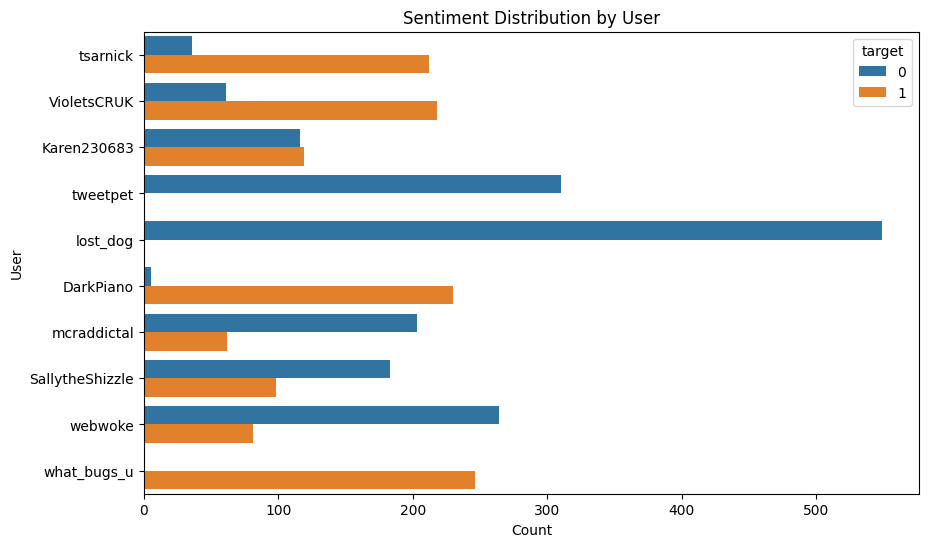

In [ ]:
# Plot the top 10 users with the most tweets
top_users = df['user'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['user'].isin(top_users.index)], y='user', hue='target')
plt.title('Sentiment Distribution by User')
plt.xlabel('Count')
plt.ylabel('User')
plt.show()


4.4 Analyze and Visualize the Length of Tweets

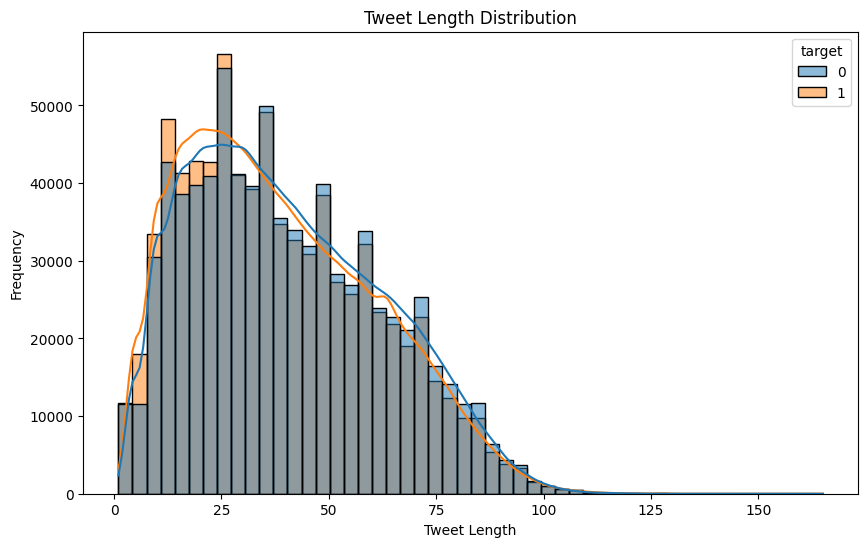

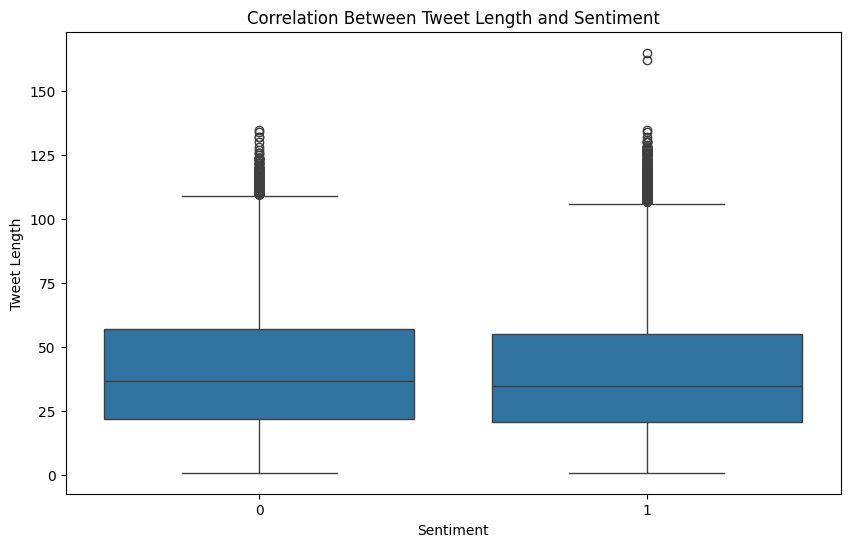

In [ ]:
# Calculate tweet lengths
df['tweet_length'] = df['text'].apply(len)

# Plot distribution of tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tweet_length', hue='target', bins=50, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# Correlation between tweet length and sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='target', y='tweet_length')
plt.title('Correlation Between Tweet Length and Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')
plt.show()


# **Step 5: Model Building**

5.1 Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


5.2 Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


5.3 Model Training with Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# **Step 6: Model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.7738848403595638
Precision: 0.7654240441713938
Recall: 0.7924474019963476
F1 Score: 0.7787013449938389


# **Step 7: Model Improvement**

7.1 Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_tfidf, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Best Model Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Model Parameters: {'C': 1, 'solver': 'newton-cg'}
Accuracy: 0.7738377441545761
Precision: 0.7655343326885881
Recall: 0.7920971655867711
F1 Score: 0.7785892565133464


# **Step 8: Model Deployment**

8.1 Save the Model

In [ ]:
import joblib

joblib.dump(best_model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

8.2 Create a Prediction Script

In [ ]:
import joblib

# Load model and vectorizer
model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

def predict_sentiment(text):
    text = clean_text(text)
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)
    return 'Positive' if prediction == 1 else 'Negative'

# Example usage
sample_text = "I love this product!"
print(predict_sentiment(sample_text))


Positive


# **Step 9: Visualize Model Performance**

9.1 Confusion Matrix

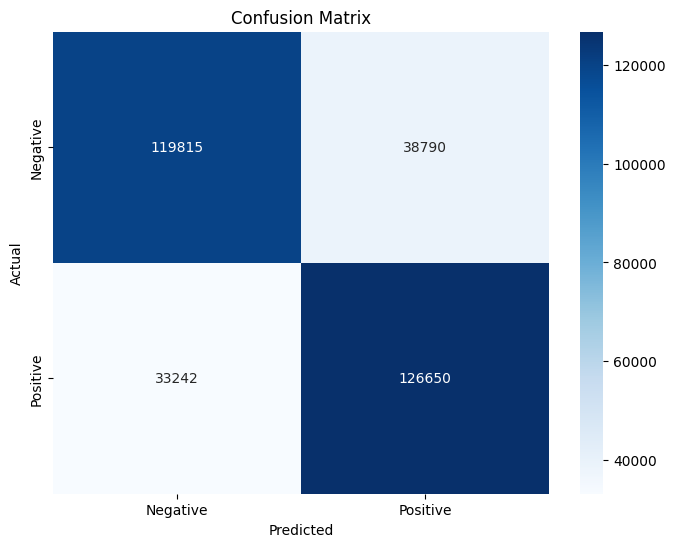

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


9.2 ROC Curve and AUC

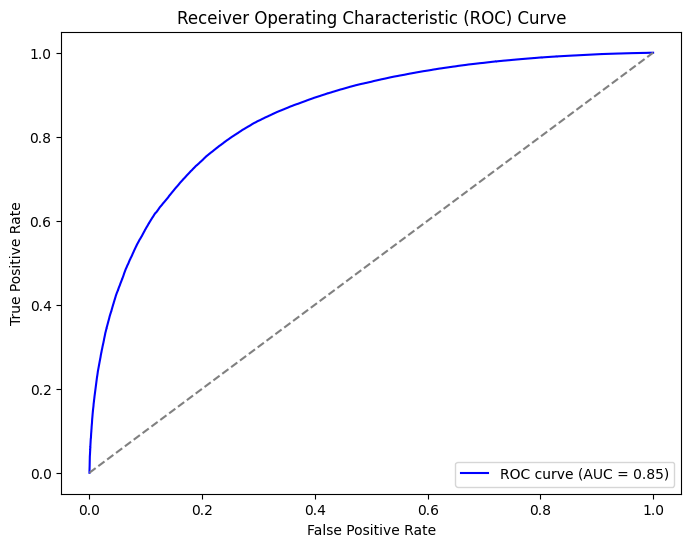

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
y_prob = model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


9.3 Precision-Recall Curve

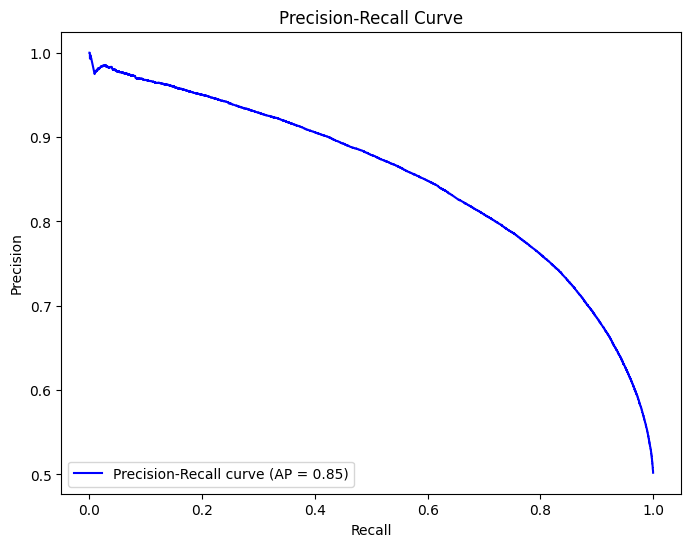

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute average precision
average_precision = average_precision_score(y_test, y_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
